[![Open In colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/DatosGeograficos/2_Joins_y_Viz/ejercicio/ejercicio-solucion.ipynb)

<h1 id="tocheading">Tabla de contenidos</h1>
<div id="toc"></div>

I. Tabla de contenidos

    I. Introducción
    II. Leo datasets
    III. Grafico .bounds
    IV. Armo función para samplear
    V. Calculo distancias y grafico histograma
    VI. Mapa con folium

In [2]:
import geopandas
geopandas.__version__

'0.7.0'

## Introducción

Trabajás en una importante Secretaría del Gobierno de la Ciudad de Buenos Aires, cumpliste tus tareas del día y, cuando te estás preparando para irte, escuchás que gritan tu nombre desde el final del pasillo... 

    - ¡Vení! ¡Rápido!, te vuelven a llamar...
    - Uy, justo me estaba yendo, es fin de semana largo, ¿vió?, decís en tu mejor tono de 'me quiero ir'...
    - Mirá, el tema es así, me llegó un mail pidiéndome información para hoy mismo acerca de qué tan lejos le quedan las comisarias a la gente en Buenos Aires. Está la hipótesis de que la gente no realiza denuncias porque la comisaria más cercana les queda muy lejos. Igual, no nos piden testear la hipótesis pero sí tener una noción de qué tan lejos estpan. 
    - Ok, me quedo tranquilo, decís, sin saber bien qué acotar...
    - Tranquilo o intranquilo, no importa eso, lo que sí importa es que tenemos que entregar algo bien hecho y ya mismo. Te pido lo siguiente, necesitamos saber cuál es la distancia promedio de una persona a la comisaria más cercana... 
    - Mmm, hay 3 millones de personas, ¿cómo hacemos?
    - Vamos a samplear puntos...
    - ¿Eh?
    - Sí, vamos a tirar puntos al azar en la ciudad y de ahí vamos a calcular la distancia a la comisaria más cercana.
    - ¿Y pero cómo hago para generar un punto al azar? ¿Miro el mapa y decido más o menos a ojo?
    - No, no, ¿cómo vas a hacer eso? Vamos a usar GeoPandas, generamos 1000 valores representativos de la superficie de la ciudad, luego calculamos la distancia de cada punto a la comisaria más cercana y mostramos cómo se distribuye esa distancia. Ojo, no es un problema trivial generar un punto al azar dentro de una geometría. Pensá que hay que garantizarse que caiga dentro del polígono... 
    - ¿y algo más?
    - Si, si, obviamente hay que mostrar un mapa, dónde cayeron los puntos, dónde están las comisarias... y también agregá la capa de los barrios. Todo filtrable, interactivo y lindo, nada de un .plot así nomás...

Y así, arrancaba la noche...Pasando en limpio el ejercio y algunos tips.

1) Cargar barrios y comisarias y pasar a GKBA. Esto después nos va a servir para que la distancia que calculamos quede en metros.

2) Los GeoDataFrames tienen el atributo .bounds que nos devuelve los valores más extremos de longitud y latitud. Esto es muy útil para acotar los valores de las muestras que vamos a tomar. Como queremos que caigan en la Ciudad de Buenos Aires pero sólo tenemos los barrios tenemos que usar **.dissolve** para quedarnos con un solo polígono. Luego, miren el .bounds de ese polígono.

2bis) BONUS TRACK: generar un mapa donde se muestren los barrios y los 4 puntos más extremos según los valores obtenidos por .bounds. O sea, el valor más al SURESTE, SUROESTE, NORESTE Y NOROESTE.

3) Generar una función que genere **n** puntos dentro de un polígono distribuidos al azar. Para hacer eso la función va a tomar los .bounds del polígono, generar un valor al azar de longitud y latitud (pueden usar **random.uniform** (googleen o pregunten si no lo encuentran) y luego fijarse si el polígono lo **contiene**. Si lo contiene guardar el punto en una lista y si no agregar += a un contador que registre cuántos puntos caen afuera (al final. Acuérdense de contar cuántos caen adentro para frenar el loop.

4) Para cada punto calcular la distancia a la comisaria más cercana.

5) Graficar un histograma.

6) Con folium (u otra librería interactiva) mostrar los puntos, los barrios y las comisarias.
    Para los puntos incluir como popup la distancia y el color del icono pintarlo en base a las siguientes reglas:
    
    if distancia < 500:
        color = "green"
    elif distancia > 500 and distancia < 1500:
        color = "blue"
    else:
        color = "red"
    
    Para las comisarias incluir como popup el nombre.

    - Bueno... me voy yendo, acordate de mandar eso cuando lo tengas... ¡Buen finde!
    - ¿Eh?, ¿no me vas a ayudar?, no lo podés creer...
    - ¡No te escucho! ¿Saludos? Ah, sí, gracias y, ¡saludos también para tu familia! ¡Y usá GeoSeries.representative_point  de CABA, no para cada barrio!

In [ ]:
# !pip install geopandas
# !apt install libspatialindex-dev
# !pip install rtree

# !pip install pysal
# !pip install contextily #--> Para importar mapa base
# !pip install folium

In [12]:
import pandas as pd
import geopandas
import shapely.wkt
import matplotlib.pyplot as plt
%matplotlib inline

## Leo datasets

In [13]:
def from_wkt(df, wkt_column, crs='EPSG:4326'):
    
    df["coordinates"]= df[wkt_column].apply(shapely.wkt.loads) # empleamos una función de shapely para leer WKT
        
    gdf = geopandas.GeoDataFrame(df, geometry='coordinates', crs=crs) # seteamos la columna de geometría
    
    return gdf

In [14]:
def from_x_y(df, x, y, crs='EPSG:4326'):
    gdf = geopandas.GeoDataFrame(df.drop([x, y], axis=1), # eliminamos las columnas originales
                                crs=crs, # Agregamos CRS
                                geometry=geopandas.points_from_xy(df[x], df[y])) # junto "x" e "y" y lo paso a Point
    return gdf

In [49]:
barrios = pd.read_csv("https://datasets-humai.s3.amazonaws.com/datasets/barrios.csv", encoding='latin1')

In [50]:
barrios = from_wkt(barrios, "WKT")

In [51]:
barrios_gkba = barrios.to_crs(crs = "+proj=tmerc +lat_0=-34.629269 +lon_0=-58.4633 +k=0.9999980000000001 +x_0=100000 +y_0=100000 +ellps=intl +units=m +no_defs")

In [52]:
comisarias = pd.read_csv("https://datasets-humai.s3.amazonaws.com/datasets/comisarias-policia-de-la-ciudad.csv")

In [53]:
comisarias = from_x_y(comisarias, "long", "lat")

In [54]:
comisarias_gkba = comisarias.to_crs(crs = "+proj=tmerc +lat_0=-34.629269 +lon_0=-58.4633 +k=0.9999980000000001 +x_0=100000 +y_0=100000 +ellps=intl +units=m +no_defs")

## Grafico .bounds

In [178]:
barrios_gkba["ciudad"] = "CABA"
caba_gkba = barrios_gkba.dissolve(by="ciudad")

In [179]:
from shapely.geometry import Point
import geopandas as gpd
import random

In [180]:
## Mapeo bounds extremos

In [181]:
caba_gkba.bounds

,minx,miny,maxx,maxy
ciudad,,,,
CABA,93743.182189,91566.108919,111752.537594,111285.206805


In [182]:
punto_1 = Point((93743.182189,  91566.108919))
punto_2 = Point((93743.182189,  111285.206805))
punto_3 = Point((111752.537594,  91566.108919))
punto_4 = Point((111752.537594,  111285.206805))

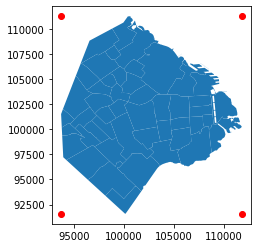

In [183]:
df = pd.DataFrame(data = {'id': [1, 2, 3, 4]}) # Armo un DataFrame
gdf = geopandas.GeoDataFrame(df, crs="EPSG:4326", geometry=[punto_1, punto_2, punto_3, punto_4])
fig, ax = plt.subplots()
gdf.plot(ax=ax,color="red", aspect=1) # sin aspect=1 da error, depende la versión
barrios_gkba.plot(ax=ax)

## Armo función para samplear

In [184]:
def puntos_al_azar(n, poligono):
    puntos = []
    # 1- obtengo valores extremos del polígono
    limites = poligono.bounds.to_dict(orient="list")
    min_x, max_x, min_y, max_y = limites["minx"][0], limites["maxx"][0], limites["miny"][0], limites["maxy"][0]
    
    i= 0 # inicio contador de puntos dentro de la geometría
    puntos_afuera = 0 # inicio contador de puntos fuera de la geometría
    while i < n:
        punto_i = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y)) #armo un punto al azar
        # Si cae adentro de la geometría lo agrego a la lisa
        if poligono.geometry.contains(punto_i).iloc[0]:
            puntos.append(punto_i)
            i += 1
        else:
            puntos_afuera += 1
    print(f"cayeron afuera: {puntos_afuera} puntos")
    return puntos  # devuelvo la lista

In [185]:
puntos_muestra = puntos_al_azar(1000, caba_gkba)

cayeron afuera: 745 puntos


In [186]:
def distancia_mas_cercana(punto, lista_de_puntos):
    distancias = []
    for p in lista_de_puntos:
        distancia_i = punto.distance(p)
        distancias.append(distancia_i)
    return min(distancias)

In [96]:
puntos_muestra = geopandas.GeoDataFrame(data = range(len(puntos_muestra)), geometry=puntos_muestra)

## Calculo distancias y grafico histograma

In [98]:
puntos_muestra["m_a_comisaria"] = puntos_muestra.geometry.apply(lambda x: distancia_mas_cercana(x, comisarias_gkba.geometry))

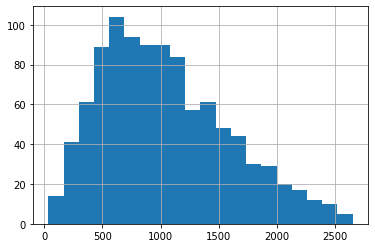

In [102]:
puntos_muestra['m_a_comisaria'].hist(bins=20)

## Mapa con folium

In [108]:
import folium
from pyproj import crs

In [111]:
gkba_crs = crs.CRS("+proj=tmerc +lat_0=-34.629269 +lon_0=-58.4633 +k=0.9999980000000001 +x_0=100000 +y_0=100000 +ellps=intl +units=m +no_defs")

In [112]:
puntos_muestra.crs = gkba_crs

In [149]:
def mapear_color(distancia):
    if distancia < 500:
        color = "green"
    elif distancia > 500 and distancia < 1500:
        color = "blue"
    else:
        color = "red"
    return color

In [151]:
puntos_muestra["color"] = puntos_muestra["m_a_comisaria"].apply(lambda x: mapear_color(x))

In [161]:
from folium.plugins import MarkerCluster

In [176]:
lat, lon = -34.603668, -58.381345 
mapa = folium.Map(location=(lat, lon), zoom_start=16)

# agrego puntos y la distancia como popup. Si la distancia está a más de 1500 m pinto el marcador de rojo
coord_muestra = list(zip(puntos_muestra.to_crs("EPSG:4326").geometry.y, puntos_muestra.to_crs("EPSG:4326").geometry.x))
iconos = [folium.Icon(color=i) for i in puntos_muestra["color"].tolist()]
distancias = puntos_muestra["m_a_comisaria"].tolist()

for i in range(len(puntos_muestra)):
    folium.Marker(coord_muestra[i], icon=iconos[i], popup=folium.Popup(distancias[i])).add_to(mapa)
    
# agrego comisarias y el nombre como popup
coord_comisarias = list(zip(comisarias.geometry.y, comisarias.geometry.x))
popups_comisarias = comisarias["nombre"].tolist()
MarkerCluster(coord_comisarias, popups=popups_comisarias).add_to(mapa)

# barrios
folium.GeoJson(barrios.to_json(), name='barrios').add_to(mapa)


folium.LayerControl(autoZIndex=False, collapsed=False).add_to(mapa)

In [177]:
mapa